# Binary Text Classification - BERT
Fine-tuning XLM-RoBERTa with channel prefix, focal loss, and data augmentation

In [1]:
import pandas as pd
import numpy as np
import re
import random
import warnings
warnings.filterwarnings('ignore')

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import AdamW
import torch.nn.functional as F

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'✓ Device: {device}')
if torch.cuda.is_available():
    print(f'  GPU: {torch.cuda.get_device_name(0)}')

✓ Device: cuda
  GPU: NVIDIA GeForce RTX 3090


In [2]:
MODEL_NAME = 'xlm-roberta-large'
USE_TEXT_CLEANING = True
MAX_LENGTH = 160
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_EPOCHS = 15
VAL_SPLIT = 0.2
RANDOM_STATE = 42
USE_CHANNEL_PREFIX = True
GRADIENT_ACCUMULATION_STEPS = 2
SAVE_MODEL = True
MODEL_SAVE_PATH = './bert_model_best'

print(f'Config: {MODEL_NAME}, {NUM_EPOCHS} epochs, batch {BATCH_SIZE}x{GRADIENT_ACCUMULATION_STEPS}={BATCH_SIZE*GRADIENT_ACCUMULATION_STEPS}')

Config: xlm-roberta-large, 15 epochs, batch 16x2=32


In [3]:
train_df = pd.read_csv('nulp-military-experience/train.csv')
test_df = pd.read_csv('nulp-military-experience/to_answer.csv')

print(f'Train: {train_df.shape}, Test: {test_df.shape}')
print(f'\nClass distribution:\n{train_df["new_label"].value_counts()}')

Train: (5299, 6), Test: (2271, 7)

Class distribution:
new_label
0.0    3830
1.0    1469
Name: count, dtype: int64


In [4]:
def clean_text_for_bert(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^А-Яа-яёЁA-Za-z0-9\s\.,!?;:()"\'-]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

if USE_TEXT_CLEANING:
    train_df['text_cleaned'] = train_df['cleaned_message'].apply(clean_text_for_bert)
    test_df['text_cleaned'] = test_df['cleaned_message'].apply(clean_text_for_bert)
else:
    train_df['text_cleaned'] = train_df['cleaned_message']
    test_df['text_cleaned'] = test_df['cleaned_message']

if USE_CHANNEL_PREFIX:
    train_df['text'] = '[' + train_df['channel_name'].astype(str) + '] ' + train_df['text_cleaned']
    test_df['text'] = '[' + test_df['channel_name'].astype(str) + '] ' + test_df['text_cleaned']
else:
    train_df['text'] = train_df['text_cleaned']
    test_df['text'] = test_df['text_cleaned']

print(f'✓ Text preprocessing done (cleaning={USE_TEXT_CLEANING}, channel_prefix={USE_CHANNEL_PREFIX})')

✓ Text preprocessing done (cleaning=True, channel_prefix=True)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
print(f'✓ Tokenizer loaded: {MODEL_NAME}')

In [6]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts[idx]),
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

print('✓ Dataset class defined')

✓ Dataset class defined


In [7]:
def augment_text_simple(text, p_delete=0.3, p_duplicate=0.3):
    if not isinstance(text, str) or len(text) < 50:
        return [text]
    
    augmented_texts = [text]
    
    if text.startswith('[') and ']' in text:
        bracket_end = text.index(']')
        channel_prefix = text[:bracket_end+1]
        content = text[bracket_end+1:].strip()
    else:
        channel_prefix = ''
        content = text
    
    words = content.split()
    if len(words) < 10:
        return augmented_texts
    
    if random.random() < p_delete:
        num_delete = max(1, int(len(words) * 0.1))
        indices_to_keep = set(range(len(words))) - set(random.sample(range(len(words)), num_delete))
        deleted_words = [words[i] for i in sorted(indices_to_keep)]
        augmented_texts.append(f'{channel_prefix} {" ".join(deleted_words)}'.strip())
    
    if random.random() < p_duplicate and len(words) >= 15:
        num_duplicate = max(1, min(3, int(len(words) * 0.05)))
        indices_to_duplicate = random.sample(range(len(words)), num_duplicate)
        duplicated_words = words.copy()
        for idx in sorted(indices_to_duplicate, reverse=True):
            duplicated_words.insert(idx + 1, words[idx])
        augmented_texts.append(f'{channel_prefix} {" ".join(duplicated_words)}'.strip())
    
    return augmented_texts

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'].values, train_df['new_label'].values,
    test_size=VAL_SPLIT, random_state=RANDOM_STATE, stratify=train_df['new_label'].values
)

random.seed(RANDOM_STATE)
class_0_mask = train_labels == 0
class_1_mask = train_labels == 1

train_texts_class_0 = train_texts[class_0_mask]
train_labels_class_0 = train_labels[class_0_mask]
train_texts_class_1 = train_texts[class_1_mask]
train_labels_class_1 = train_labels[class_1_mask]

augmented_texts_class_1 = []
augmented_labels_class_1 = []
for text in train_texts_class_1:
    aug_texts = augment_text_simple(text)
    augmented_texts_class_1.extend(aug_texts)
    augmented_labels_class_1.extend([1] * len(aug_texts))

train_texts_final = np.concatenate([train_texts_class_0, np.array(augmented_texts_class_1)])
train_labels_final = np.concatenate([train_labels_class_0, np.array(augmented_labels_class_1)])
shuffle_indices = np.random.permutation(len(train_texts_final))
train_texts = train_texts_final[shuffle_indices]
train_labels = train_labels_final[shuffle_indices]

print(f'Data split: train={len(train_texts)}, val={len(val_texts)}, test={len(test_df)}')
print(f'Augmentation: class_1 {len(train_texts_class_1)}→{len(augmented_texts_class_1)} ({len(augmented_texts_class_1)/len(train_texts_class_1):.2f}x)')

train_dataset = TextDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
val_dataset = TextDataset(val_texts, val_labels, tokenizer, MAX_LENGTH)
test_dataset = TextDataset(test_df['text'].values, np.zeros(len(test_df)), tokenizer, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'✓ DataLoaders: {len(train_loader)} train batches, {len(val_loader)} val batches')

Data split: train=4913, val=1060, test=2271
Augmentation: class_1 1175→1849 (1.57x)
✓ DataLoaders: 308 train batches, 67 val batches


In [8]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)
print(f'✓ Model loaded: {sum(p.numel() for p in model.parameters()):,} parameters')

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded: 559,892,482 parameters


In [9]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)
print(f'✓ Optimizer: AdamW (lr={LEARNING_RATE}, steps={total_steps}, warmup={int(0.1*total_steps)})')

✓ Optimizer: AdamW (lr=2e-05, steps=4620, warmup=462)


In [10]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, logits, labels):
        ce_loss = F.cross_entropy(logits, labels, reduction='none')
        probs = F.softmax(logits, dim=1)
        pt = probs.gather(1, labels.unsqueeze(1)).squeeze(1)
        focal_weight = (1 - pt) ** self.gamma
        alpha_weight = torch.where(
            labels == 1,
            torch.tensor(self.alpha, device=labels.device),
            torch.tensor(1 - self.alpha, device=labels.device)
        )
        loss = alpha_weight * focal_weight * ce_loss
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

focal_loss_fn = FocalLoss(alpha=0.75, gamma=2.0)
print('✓ Focal Loss (alpha=0.75, gamma=2.0)')

✓ Focal Loss (alpha=0.75, gamma=2.0)


In [11]:
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []
    
    optimizer.zero_grad()
    
    progress_bar = tqdm(dataloader, desc='Training')
    for step, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = focal_loss_fn(outputs.logits, labels)
        loss = loss / GRADIENT_ACCUMULATION_STEPS
        total_loss += loss.item() * GRADIENT_ACCUMULATION_STEPS
        
        loss.backward()
        
        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        
        progress_bar.set_postfix({'loss': loss.item() * GRADIENT_ACCUMULATION_STEPS})
    
    if len(dataloader) % GRADIENT_ACCUMULATION_STEPS != 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    
    return avg_loss, accuracy


def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc='Evaluating')
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = focal_loss_fn(outputs.logits, labels)
            total_loss += loss.item()
            
            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    
    return avg_loss, accuracy, f1, predictions, true_labels

print('✓ Training functions defined')

✓ Training functions defined


In [12]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
best_val_f1 = 0
best_model_state = None

print('='*80)
print('TRAINING')
print('='*80)

for epoch in range(NUM_EPOCHS):
    print(f'\nEpoch {epoch + 1}/{NUM_EPOCHS}')
    print('-' * 80)
    
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
    val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    print(f'\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f} | Val F1: {val_f1:.4f}')
    
    if val_f1 > best_val_f1:
        improvement = val_f1 - best_val_f1
        best_val_f1 = val_f1
        best_model_state = model.state_dict().copy()
        print(f'✓ New best! (F1: {val_f1:.4f}, +{improvement:.4f})')
    else:
        print(f'  No improvement')

print('='*80)
print(f'TRAINING COMPLETED - Best F1: {best_val_f1:.4f}')
print('='*80)

model.load_state_dict(best_model_state)
print('✓ Best model loaded')

TRAINING

Epoch 1/15
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 67/67 [00:08<00:00,  8.13it/s]



Train Loss: 0.0629 | Train Acc: 0.5626
Val Loss:   0.0373 | Val Acc:   0.8377 | Val F1: 0.7550
✓ New best! (F1: 0.7550, +0.7550)

Epoch 2/15
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 67/67 [00:07<00:00,  8.90it/s]



Train Loss: 0.0385 | Train Acc: 0.8423
Val Loss:   0.0479 | Val Acc:   0.8877 | Val F1: 0.7742
✓ New best! (F1: 0.7742, +0.0192)

Epoch 3/15
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 67/67 [00:07<00:00,  8.82it/s]



Train Loss: 0.0313 | Train Acc: 0.8893
Val Loss:   0.0470 | Val Acc:   0.9094 | Val F1: 0.8280
✓ New best! (F1: 0.8280, +0.0538)

Epoch 4/15
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 67/67 [00:08<00:00,  8.36it/s]



Train Loss: 0.0214 | Train Acc: 0.9298
Val Loss:   0.0398 | Val Acc:   0.8698 | Val F1: 0.7959
  No improvement

Epoch 5/15
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 67/67 [00:07<00:00,  8.67it/s]



Train Loss: 0.0158 | Train Acc: 0.9564
Val Loss:   0.0556 | Val Acc:   0.8849 | Val F1: 0.8045
  No improvement

Epoch 6/15
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 67/67 [00:07<00:00,  8.97it/s]



Train Loss: 0.0085 | Train Acc: 0.9746
Val Loss:   0.0623 | Val Acc:   0.9066 | Val F1: 0.8302
✓ New best! (F1: 0.8302, +0.0022)

Epoch 7/15
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 67/67 [00:07<00:00,  9.19it/s]



Train Loss: 0.0048 | Train Acc: 0.9868
Val Loss:   0.1850 | Val Acc:   0.9047 | Val F1: 0.8147
  No improvement

Epoch 8/15
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 67/67 [00:07<00:00,  8.83it/s]



Train Loss: 0.0041 | Train Acc: 0.9886
Val Loss:   0.0903 | Val Acc:   0.8972 | Val F1: 0.8143
  No improvement

Epoch 9/15
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 67/67 [00:07<00:00,  8.80it/s]



Train Loss: 0.0025 | Train Acc: 0.9941
Val Loss:   0.1439 | Val Acc:   0.9009 | Val F1: 0.8161
  No improvement

Epoch 10/15
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 67/67 [00:08<00:00,  8.22it/s]



Train Loss: 0.0013 | Train Acc: 0.9967
Val Loss:   0.1970 | Val Acc:   0.8991 | Val F1: 0.8029
  No improvement

Epoch 11/15
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 67/67 [00:07<00:00,  8.54it/s]



Train Loss: 0.0019 | Train Acc: 0.9967
Val Loss:   0.1670 | Val Acc:   0.9009 | Val F1: 0.8235
  No improvement

Epoch 12/15
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 67/67 [00:07<00:00,  8.75it/s]



Train Loss: 0.0021 | Train Acc: 0.9949
Val Loss:   0.2254 | Val Acc:   0.9009 | Val F1: 0.8008
  No improvement

Epoch 13/15
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 67/67 [00:07<00:00,  8.67it/s]



Train Loss: 0.0022 | Train Acc: 0.9959
Val Loss:   0.2127 | Val Acc:   0.9009 | Val F1: 0.8073
  No improvement

Epoch 14/15
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 67/67 [00:07<00:00,  9.14it/s]



Train Loss: 0.0014 | Train Acc: 0.9976
Val Loss:   0.1429 | Val Acc:   0.8943 | Val F1: 0.8146
  No improvement

Epoch 15/15
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 67/67 [00:07<00:00,  9.08it/s]


Train Loss: 0.0003 | Train Acc: 0.9992
Val Loss:   0.1627 | Val Acc:   0.8925 | Val F1: 0.8041
  No improvement
TRAINING COMPLETED - Best F1: 0.8302
✓ Best model loaded


In [13]:
if SAVE_MODEL:
    model.save_pretrained(MODEL_SAVE_PATH)
    tokenizer.save_pretrained(MODEL_SAVE_PATH)
    print(f'✓ Model saved to {MODEL_SAVE_PATH}')

✓ Model saved to ./bert_model_best


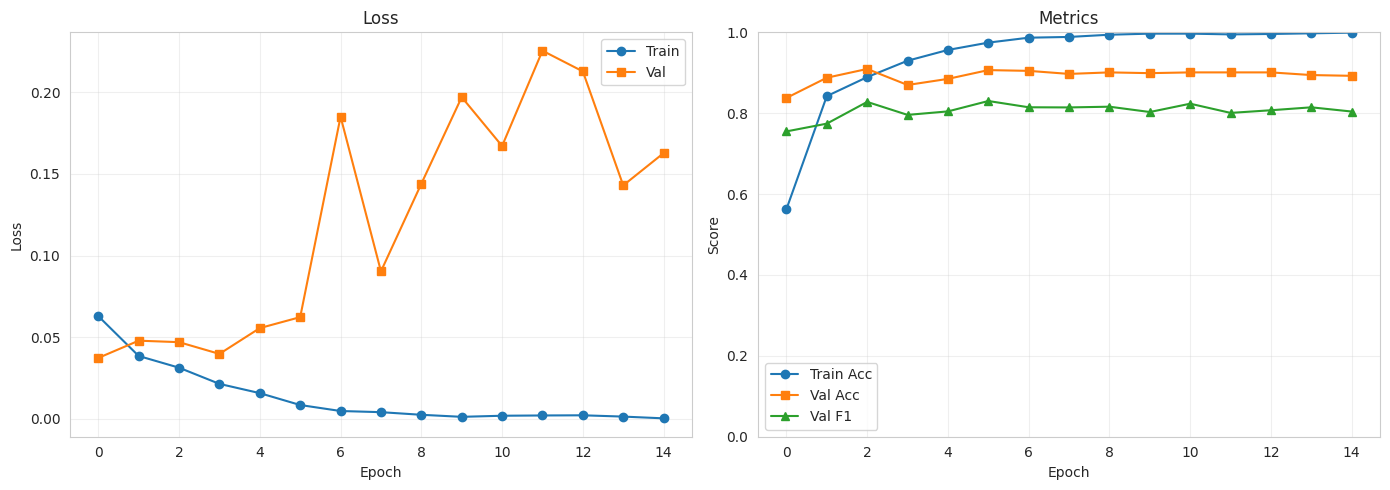

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['train_loss'], label='Train', marker='o')
axes[0].plot(history['val_loss'], label='Val', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].plot(history['val_f1'], label='Val F1', marker='^')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Metrics')
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_ylim(0, 1.0)

plt.tight_layout()
plt.show()

In [15]:
val_loss, val_acc, val_f1, val_preds, val_labels = evaluate(model, val_loader, device)

precision = precision_score(val_labels, val_preds)
recall = recall_score(val_labels, val_preds)
cm = confusion_matrix(val_labels, val_preds)

print('='*80)
print('VALIDATION METRICS')
print('='*80)
print(f'Accuracy:  {val_acc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1-Score:  {val_f1:.4f}')
print('='*80)
print('\n' + classification_report(val_labels, val_preds, target_names=['Class 0', 'Class 1']))

Evaluating: 100%|██████████| 67/67 [00:07<00:00,  9.28it/s]

VALIDATION METRICS
Accuracy:  0.8925
Precision: 0.8125
Recall:    0.7959
F1-Score:  0.8041

              precision    recall  f1-score   support

     Class 0       0.92      0.93      0.93       766
     Class 1       0.81      0.80      0.80       294

    accuracy                           0.89      1060
   macro avg       0.87      0.86      0.87      1060
weighted avg       0.89      0.89      0.89      1060



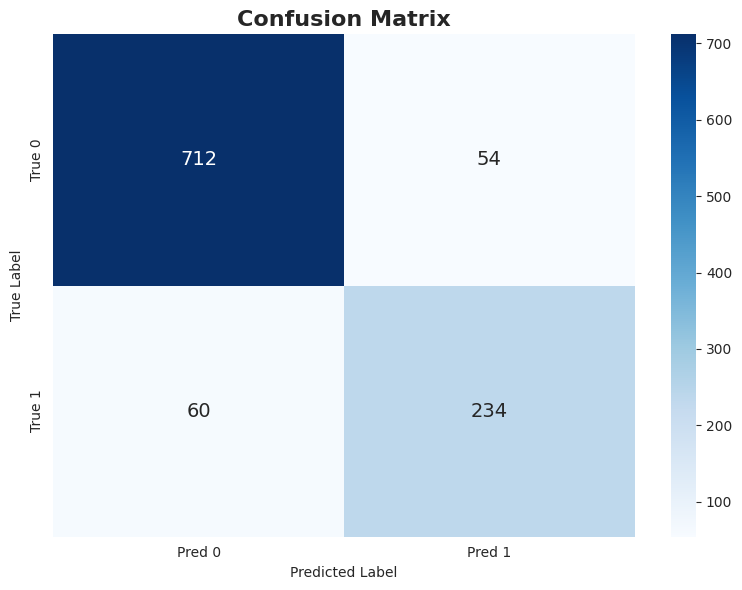

TN: 712, FP: 54, FN: 60, TP: 234


In [16]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['True 0', 'True 1'],
            annot_kws={'size': 14})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')

In [21]:
model.eval()
test_predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Predicting'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        test_predictions.extend(preds.cpu().numpy())

submission = test_df[['row ID']].copy()
submission['predicted_label'] = [int(p) for p in test_predictions]
submission[['row ID', 'predicted_label']].to_csv('predictions_bert.csv', index=False)

print(f'✓ Predictions saved to predictions_bert.csv')
print(f'Distribution: {submission["predicted_label"].value_counts().to_dict()}')

Predicting: 100%|██████████| 142/142 [00:16<00:00,  8.75it/s]

✓ Predictions saved to predictions_bert.csv
Distribution: {0: 1638, 1: 633}


## Advanced Visualizations & Analysis


In [26]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

print('Computing validation probabilities...')
model.eval()
val_probs = []
val_true_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc='Computing probabilities'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = F.softmax(outputs.logits, dim=1)
        val_probs.extend(probs[:, 1].cpu().numpy())
        val_true_labels.extend(labels.cpu().numpy())

val_probs = np.array(val_probs)
val_true_labels = np.array(val_true_labels)

# Create validation dataframe for error analysis
val_text_df = pd.DataFrame({
    'text': val_texts,
    'label': val_labels,
    'pred': val_preds,
    'probability': val_probs,
    'confidence': np.abs(val_probs - 0.5),
    'correct': val_labels == val_preds
})

print(f'✓ Setup complete: val_probs shape={val_probs.shape}, val_text_df shape={val_text_df.shape}')

Computing validation probabilities...


Computing probabilities: 100%|██████████| 67/67 [00:08<00:00,  8.21it/s]

✓ Setup complete: val_probs shape=(1060,), val_text_df shape=(1060, 6)


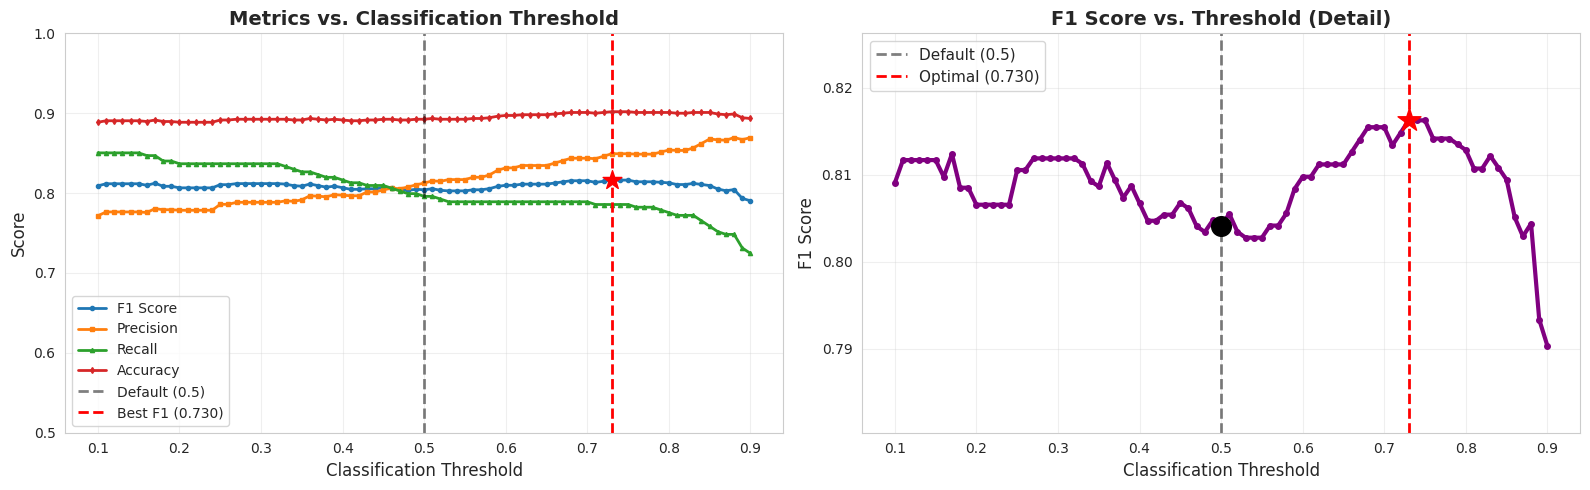

THRESHOLD OPTIMIZATION
\nCurrent threshold (0.5):
  F1:        0.8041
  Precision: 0.8125
  Recall:    0.7959
  Accuracy:  0.8925
\nOptimal threshold (0.730):
  F1:        0.8163 (+0.0121)
  Precision: 0.8493 (+0.0368)
  Recall:    0.7857 (-0.0102)
  Accuracy:  0.9019 (+0.0094)


In [27]:
# Threshold Optimization Analysis
thresholds_to_test = np.linspace(0.1, 0.9, 81)
f1_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []

for threshold in thresholds_to_test:
    preds_at_threshold = (val_probs >= threshold).astype(int)
    f1_scores.append(f1_score(val_true_labels, preds_at_threshold))
    precision_scores.append(precision_score(val_true_labels, preds_at_threshold))
    recall_scores.append(recall_score(val_true_labels, preds_at_threshold))
    accuracy_scores.append(accuracy_score(val_true_labels, preds_at_threshold))

best_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds_to_test[best_f1_idx]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot metrics vs threshold
axes[0].plot(thresholds_to_test, f1_scores, label='F1 Score', linewidth=2, marker='o', markersize=3)
axes[0].plot(thresholds_to_test, precision_scores, label='Precision', linewidth=2, marker='s', markersize=3)
axes[0].plot(thresholds_to_test, recall_scores, label='Recall', linewidth=2, marker='^', markersize=3)
axes[0].plot(thresholds_to_test, accuracy_scores, label='Accuracy', linewidth=2, marker='d', markersize=3)
axes[0].axvline(x=0.5, color='black', linestyle='--', linewidth=2, alpha=0.5, label='Default (0.5)')
axes[0].axvline(x=best_threshold, color='red', linestyle='--', linewidth=2, label=f'Best F1 ({best_threshold:.3f})')
axes[0].scatter([best_threshold], [f1_scores[best_f1_idx]], color='red', s=200, zorder=5, marker='*')
axes[0].set_xlabel('Classification Threshold', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Metrics vs. Classification Threshold', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].set_ylim([0.5, 1.0])

# Zoom in on F1 score
axes[1].plot(thresholds_to_test, f1_scores, linewidth=3, color='purple', marker='o', markersize=4)
axes[1].axvline(x=0.5, color='black', linestyle='--', linewidth=2, alpha=0.5, label='Default (0.5)')
axes[1].axvline(x=best_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal ({best_threshold:.3f})')
axes[1].scatter([best_threshold], [f1_scores[best_f1_idx]], color='red', s=300, zorder=5, marker='*')
axes[1].scatter([0.5], [f1_scores[np.argmin(np.abs(thresholds_to_test - 0.5))]], color='black', s=200, zorder=5, marker='o')
axes[1].set_xlabel('Classification Threshold', fontsize=12)
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].set_title('F1 Score vs. Threshold (Detail)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)
axes[1].set_ylim([min(f1_scores) - 0.01, max(f1_scores) + 0.01])

plt.tight_layout()
plt.show()

print('='*80)
print('THRESHOLD OPTIMIZATION')
print('='*80)
print(f'\\nCurrent threshold (0.5):')
print(f'  F1:        {f1_scores[np.argmin(np.abs(thresholds_to_test - 0.5))]:.4f}')
print(f'  Precision: {precision_scores[np.argmin(np.abs(thresholds_to_test - 0.5))]:.4f}')
print(f'  Recall:    {recall_scores[np.argmin(np.abs(thresholds_to_test - 0.5))]:.4f}')
print(f'  Accuracy:  {accuracy_scores[np.argmin(np.abs(thresholds_to_test - 0.5))]:.4f}')

print(f'\\nOptimal threshold ({best_threshold:.3f}):')
print(f'  F1:        {f1_scores[best_f1_idx]:.4f} ({"+" if f1_scores[best_f1_idx] > f1_scores[40] else ""}{f1_scores[best_f1_idx] - f1_scores[40]:.4f})')
print(f'  Precision: {precision_scores[best_f1_idx]:.4f} ({"+" if precision_scores[best_f1_idx] > precision_scores[40] else ""}{precision_scores[best_f1_idx] - precision_scores[40]:.4f})')
print(f'  Recall:    {recall_scores[best_f1_idx]:.4f} ({"+" if recall_scores[best_f1_idx] > recall_scores[40] else ""}{recall_scores[best_f1_idx] - recall_scores[40]:.4f})')
print(f'  Accuracy:  {accuracy_scores[best_f1_idx]:.4f} ({"+" if accuracy_scores[best_f1_idx] > accuracy_scores[40] else ""}{accuracy_scores[best_f1_idx] - accuracy_scores[40]:.4f})')
print('='*80)

In [ ]:
# Error Analysis - Examine Misclassified Examples
val_text_df['probability'] = val_probs
val_text_df['confidence'] = np.abs(val_probs - 0.5)

# False Positives and False Negatives
false_positives = val_text_df[(val_text_df['label'] == 0) & (val_text_df['pred'] == 1)].sort_values('probability', ascending=False)
false_negatives = val_text_df[(val_text_df['label'] == 1) & (val_text_df['pred'] == 0)].sort_values('probability', ascending=True)
true_positives = val_text_df[(val_text_df['label'] == 1) & (val_text_df['pred'] == 1)].sort_values('probability', ascending=False)
true_negatives = val_text_df[(val_text_df['label'] == 0) & (val_text_df['pred'] == 0)].sort_values('probability', ascending=True)

print('='*100)
print('ERROR ANALYSIS - MISCLASSIFIED EXAMPLES')
print('='*100)

print(f'\nFalse Positives (FP): {len(false_positives)} cases')
print(f'False Negatives (FN): {len(false_negatives)} cases')
print(f'\nTop 5 Most Confident False Positives (predicted Class 1, actually Class 0):')
print('-'*100)
for idx, (i, row) in enumerate(false_positives.head(5).iterrows(), 1):
    text_clean = row["text"].replace('\n', ' ').replace('\r', ' ').replace('  ', ' ').strip()
    print(f'{idx}. [Prob: {row["probability"]:.4f}] {text_clean[:150]}...')
    print()

print('\nTop 5 Most Confident False Negatives (predicted Class 0, actually Class 1):')
print('-'*100)
for idx, (i, row) in enumerate(false_negatives.head(5).iterrows(), 1):
    text_clean = row["text"].replace('\n', ' ').replace('\r', ' ').replace('  ', ' ').strip()
    print(f'{idx}. [Prob: {row["probability"]:.4f}] {text_clean[:150]}...')
    print()

# Visualize error distribution by confidence
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# FP and FN by confidence
axes[0].hist(false_positives['probability'], bins=30, alpha=0.7, label='False Positives', color='orange', edgecolor='black')
axes[0].hist(1 - false_negatives['probability'], bins=30, alpha=0.7, label='False Negatives', color='red', edgecolor='black')
axes[0].set_xlabel('Model Confidence', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Misclassified Examples by Confidence', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Error rate by confidence bins
confidence_bins = np.linspace(0, 0.5, 11)
error_rates = []
bin_centers = []
bin_counts = []

for i in range(len(confidence_bins) - 1):
    mask = (val_text_df['confidence'] >= confidence_bins[i]) & (val_text_df['confidence'] < confidence_bins[i+1])
    if mask.sum() > 0:
        error_rate = (~val_text_df[mask]['correct']).mean()
        error_rates.append(error_rate)
        bin_centers.append((confidence_bins[i] + confidence_bins[i+1]) / 2)
        bin_counts.append(mask.sum())

axes[1].plot(bin_centers, error_rates, marker='o', linewidth=2, markersize=8, color='red')
axes[1].fill_between(bin_centers, 0, error_rates, alpha=0.3, color='red')
axes[1].set_xlabel('Confidence (distance from 0.5)', fontsize=12)
axes[1].set_ylabel('Error Rate', fontsize=12)
axes[1].set_title('Error Rate vs. Prediction Confidence', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].set_ylim([0, max(error_rates) * 1.2])

# Add count annotations
for x, y, count in zip(bin_centers, error_rates, bin_counts):
    axes[1].text(x, y + max(error_rates)*0.03, f'n={count}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f'\nConfidence-based error analysis:')
print(f'  Low confidence (< 0.1 from threshold): {(val_text_df["confidence"] < 0.1).sum()} samples, '\
      f'Error rate: {(~val_text_df[val_text_df["confidence"] < 0.1]["correct"]).mean():.2%}')
print(f'  High confidence (> 0.4 from threshold): {(val_text_df["confidence"] > 0.4).sum()} samples, '\
      f'Error rate: {(~val_text_df[val_text_df["confidence"] > 0.4]["correct"]).mean():.2%}')

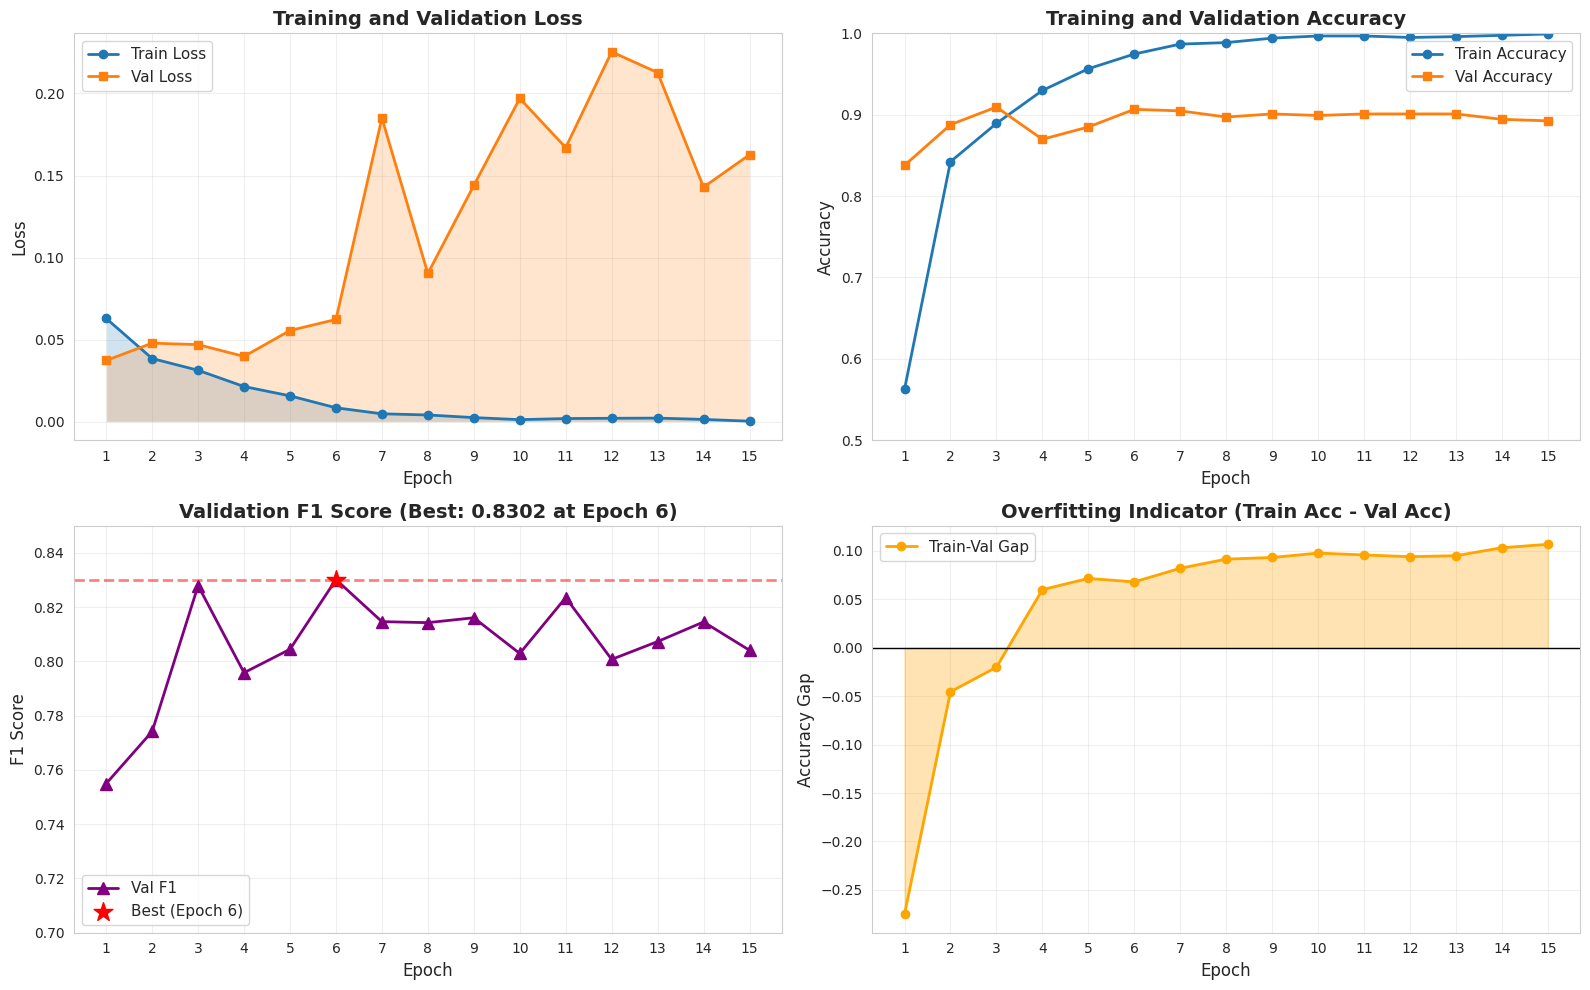

\nEpoch-by-Epoch Summary:
Epoch | Train Loss | Train Acc |   Val Loss |   Val Acc |    Val F1 |       Note
    1 |     0.0629 |    0.5626 |     0.0373 |    0.8377 |    0.7550 |           
    2 |     0.0385 |    0.8423 |     0.0479 |    0.8877 |    0.7742 |           
    3 |     0.0313 |    0.8893 |     0.0470 |    0.9094 |    0.8280 |           
    4 |     0.0214 |    0.9298 |     0.0398 |    0.8698 |    0.7959 |           
    5 |     0.0158 |    0.9564 |     0.0556 |    0.8849 |    0.8045 |           
    6 |     0.0085 |    0.9746 |     0.0623 |    0.9066 |    0.8302 |     ★ BEST
    7 |     0.0048 |    0.9868 |     0.1850 |    0.9047 |    0.8147 |  ↓ -0.0155
    8 |     0.0041 |    0.9886 |     0.0903 |    0.8972 |    0.8143 |  ↓ -0.0159
    9 |     0.0025 |    0.9941 |     0.1439 |    0.9009 |    0.8161 |  ↓ -0.0141
   10 |     0.0013 |    0.9967 |     0.1970 |    0.8991 |    0.8029 |  ↓ -0.0272
   11 |     0.0019 |    0.9967 |     0.1670 |    0.9009 |    0.8235 |  ↓ -0.0067
  

In [29]:
# Training Dynamics - Detailed Epoch Performance
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

epochs = range(1, NUM_EPOCHS + 1)

# Loss with smoothing
axes[0, 0].plot(epochs, history['train_loss'], marker='o', label='Train Loss', linewidth=2, markersize=6)
axes[0, 0].plot(epochs, history['val_loss'], marker='s', label='Val Loss', linewidth=2, markersize=6)
axes[0, 0].fill_between(epochs, history['train_loss'], alpha=0.2)
axes[0, 0].fill_between(epochs, history['val_loss'], alpha=0.2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_xticks(epochs)

# Accuracy
axes[0, 1].plot(epochs, history['train_acc'], marker='o', label='Train Accuracy', linewidth=2, markersize=6)
axes[0, 1].plot(epochs, history['val_acc'], marker='s', label='Val Accuracy', linewidth=2, markersize=6)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_ylim([0.5, 1.0])
axes[0, 1].set_xticks(epochs)

# F1 Score with best marker
best_epoch = np.argmax(history['val_f1']) + 1
axes[1, 0].plot(epochs, history['val_f1'], marker='^', label='Val F1', linewidth=2, markersize=8, color='purple')
axes[1, 0].scatter([best_epoch], [history['val_f1'][best_epoch-1]], 
                   color='red', s=200, zorder=5, label=f'Best (Epoch {best_epoch})', marker='*')
axes[1, 0].axhline(y=best_val_f1, color='red', linestyle='--', linewidth=2, alpha=0.5)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('F1 Score', fontsize=12)
axes[1, 0].set_title(f'Validation F1 Score (Best: {best_val_f1:.4f} at Epoch {best_epoch})', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_ylim([0.7, 0.85])
axes[1, 0].set_xticks(epochs)

# Overfitting indicator (train - val gap)
acc_gap = np.array(history['train_acc']) - np.array(history['val_acc'])
axes[1, 1].plot(epochs, acc_gap, marker='o', linewidth=2, markersize=6, color='orange', label='Train-Val Gap')
axes[1, 1].fill_between(epochs, 0, acc_gap, alpha=0.3, color='orange')
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Accuracy Gap', fontsize=12)
axes[1, 1].set_title('Overfitting Indicator (Train Acc - Val Acc)', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xticks(epochs)

plt.tight_layout()
plt.show()

# Print epoch-by-epoch summary
print('\\nEpoch-by-Epoch Summary:')
print('='*90)
print(f'{"Epoch":>5} | {"Train Loss":>10} | {"Train Acc":>9} | {"Val Loss":>10} | {"Val Acc":>9} | {"Val F1":>9} | {"Note":>10}')
print('='*90)
for i in range(NUM_EPOCHS):
    note = ''
    if i == best_epoch - 1:
        note = '★ BEST'
    elif i > best_epoch - 1:
        note = f'↓ -{(best_val_f1 - history["val_f1"][i]):.4f}'
    print(f'{i+1:>5} | {history["train_loss"][i]:>10.4f} | {history["train_acc"][i]:>9.4f} | '\
          f'{history["val_loss"][i]:>10.4f} | {history["val_acc"][i]:>9.4f} | {history["val_f1"][i]:>9.4f} | {note:>10}')
print('='*90)

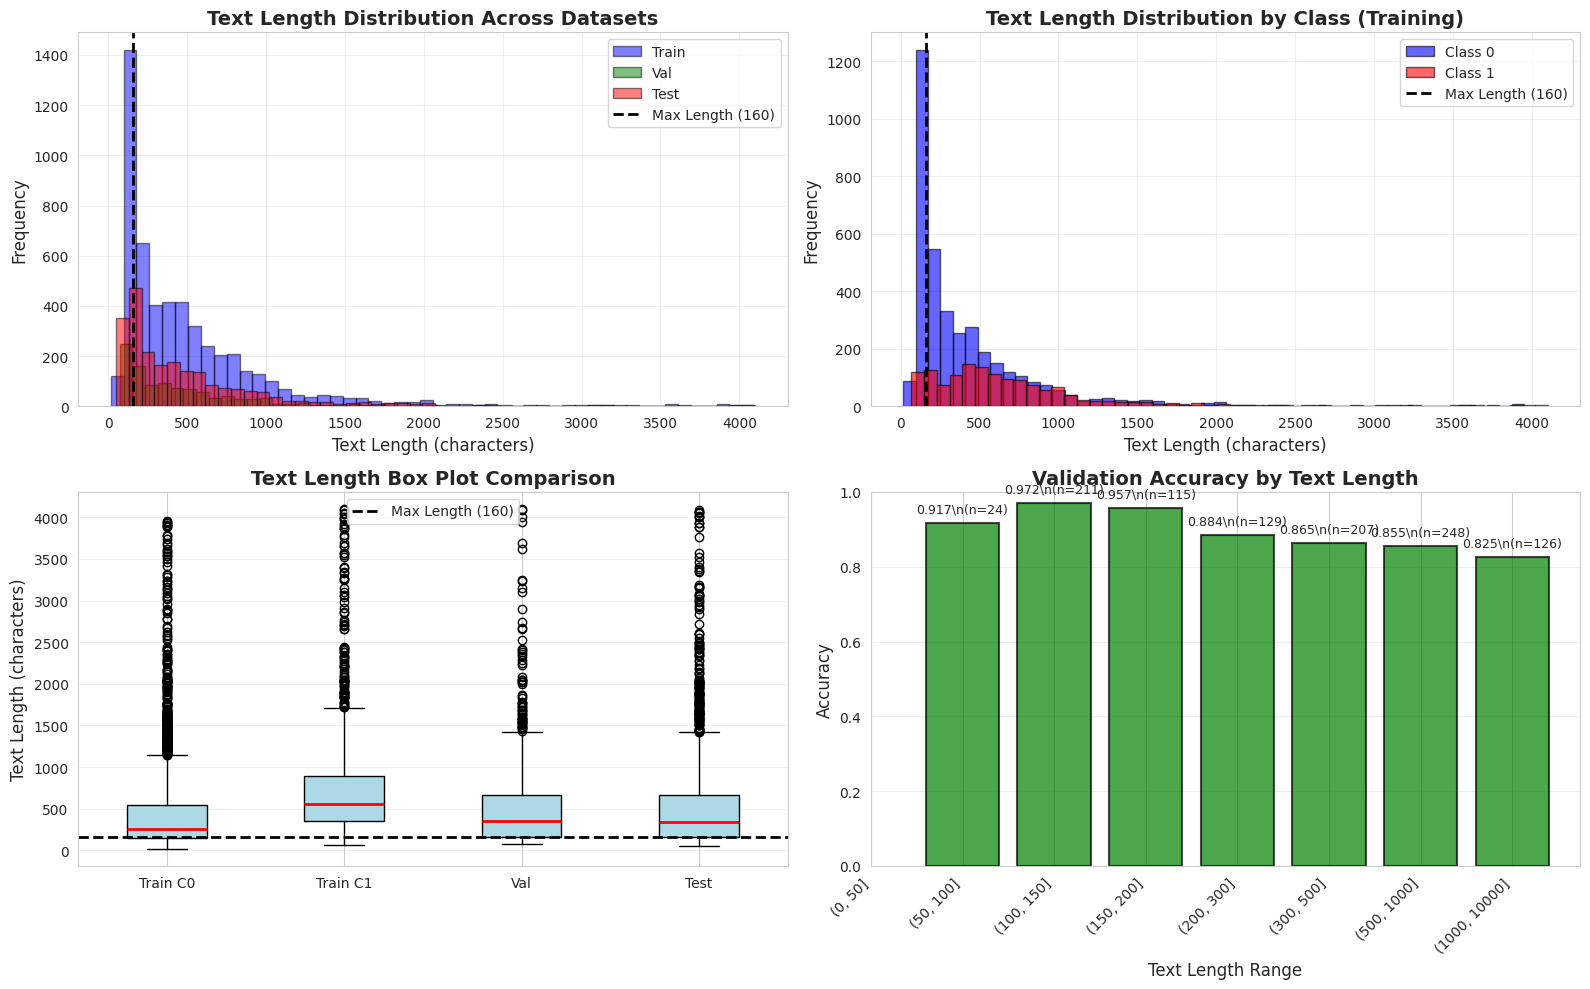

Train - Mean: 524.8, Median: 357.0, Max: 4101
Val   - Mean: 517.3, Median: 355.5, Max: 4101
Test  - Mean: 532.9, Median: 342.0, Max: 4094
\nTexts exceeding MAX_LENGTH (160):
  Train: 4004 (75.56%)
  Val:   796 (75.09%)
  Test:  1706 (75.12%)


In [30]:
# Text Length Analysis
train_lengths = train_df['text'].str.len()
val_text_df = pd.DataFrame({'text': val_texts, 'label': val_labels})
val_lengths = val_text_df['text'].str.len()
test_lengths = test_df['text'].str.len()

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Overall length distribution
axes[0, 0].hist(train_lengths, bins=50, alpha=0.5, label='Train', color='blue', edgecolor='black')
axes[0, 0].hist(val_lengths, bins=50, alpha=0.5, label='Val', color='green', edgecolor='black')
axes[0, 0].hist(test_lengths, bins=50, alpha=0.5, label='Test', color='red', edgecolor='black')
axes[0, 0].axvline(x=MAX_LENGTH, color='black', linestyle='--', linewidth=2, label=f'Max Length ({MAX_LENGTH})')
axes[0, 0].set_xlabel('Text Length (characters)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Text Length Distribution Across Datasets', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Length by class (training data)
train_class_0_lengths = train_df[train_df['new_label'] == 0]['text'].str.len()
train_class_1_lengths = train_df[train_df['new_label'] == 1]['text'].str.len()
axes[0, 1].hist(train_class_0_lengths, bins=50, alpha=0.6, label='Class 0', color='blue', edgecolor='black')
axes[0, 1].hist(train_class_1_lengths, bins=50, alpha=0.6, label='Class 1', color='red', edgecolor='black')
axes[0, 1].axvline(x=MAX_LENGTH, color='black', linestyle='--', linewidth=2, label=f'Max Length ({MAX_LENGTH})')
axes[0, 1].set_xlabel('Text Length (characters)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Text Length Distribution by Class (Training)', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Box plot comparison
data_for_box = [train_class_0_lengths, train_class_1_lengths, val_lengths, test_lengths]
axes[1, 0].boxplot(data_for_box, labels=['Train C0', 'Train C1', 'Val', 'Test'], patch_artist=True,
                   boxprops=dict(facecolor='lightblue', color='black'),
                   medianprops=dict(color='red', linewidth=2))
axes[1, 0].axhline(y=MAX_LENGTH, color='black', linestyle='--', linewidth=2, label=f'Max Length ({MAX_LENGTH})')
axes[1, 0].set_ylabel('Text Length (characters)', fontsize=12)
axes[1, 0].set_title('Text Length Box Plot Comparison', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='y')
axes[1, 0].legend()

# Error analysis by text length
val_text_df['length'] = val_lengths.values
val_text_df['pred'] = val_preds
val_text_df['correct'] = val_text_df['label'] == val_text_df['pred']

length_bins = [0, 50, 100, 150, 200, 300, 500, 1000, 10000]
val_text_df['length_bin'] = pd.cut(val_text_df['length'], bins=length_bins)
accuracy_by_length = val_text_df.groupby('length_bin')['correct'].agg(['mean', 'count'])

axes[1, 1].bar(range(len(accuracy_by_length)), accuracy_by_length['mean'], 
               color='green', alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 1].set_xticks(range(len(accuracy_by_length)))
axes[1, 1].set_xticklabels([str(interval) for interval in accuracy_by_length.index], rotation=45, ha='right')
axes[1, 1].set_ylabel('Accuracy', fontsize=12)
axes[1, 1].set_xlabel('Text Length Range', fontsize=12)
axes[1, 1].set_title('Validation Accuracy by Text Length', fontsize=14, fontweight='bold')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(alpha=0.3, axis='y')

# Add count labels
for i, (acc, count) in enumerate(zip(accuracy_by_length['mean'], accuracy_by_length['count'])):
    axes[1, 1].text(i, acc + 0.02, f'{acc:.3f}\\n(n={count})', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f'Train - Mean: {train_lengths.mean():.1f}, Median: {train_lengths.median():.1f}, Max: {train_lengths.max()}')
print(f'Val   - Mean: {val_lengths.mean():.1f}, Median: {val_lengths.median():.1f}, Max: {val_lengths.max()}')
print(f'Test  - Mean: {test_lengths.mean():.1f}, Median: {test_lengths.median():.1f}, Max: {test_lengths.max()}')
print(f'\\nTexts exceeding MAX_LENGTH ({MAX_LENGTH}):')
print(f'  Train: {(train_lengths > MAX_LENGTH).sum()} ({100*(train_lengths > MAX_LENGTH).mean():.2f}%)')
print(f'  Val:   {(val_lengths > MAX_LENGTH).sum()} ({100*(val_lengths > MAX_LENGTH).mean():.2f}%)')
print(f'  Test:  {(test_lengths > MAX_LENGTH).sum()} ({100*(test_lengths > MAX_LENGTH).mean():.2f}%)')

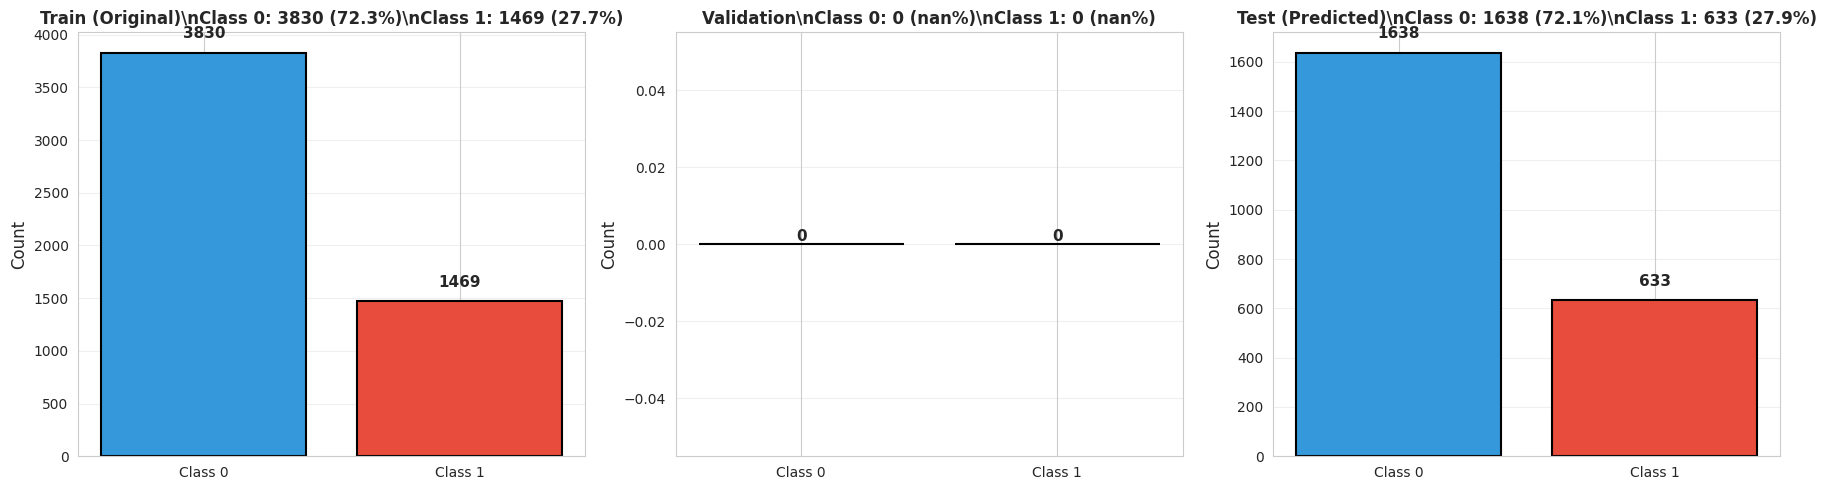

Class balance comparison:
Train:      27.72% positive class
Validation: nan% positive class
Test pred:  27.87% positive class


In [31]:
# Class Distribution Comparison Across Datasets
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets = ['Train (Original)', 'Validation', 'Test (Predicted)']
class_0_counts = [
    np.sum(train_df['new_label'] == 0),
    np.sum(val_labels == 0),
    np.sum(submission['predicted_label'] == 0)
]
class_1_counts = [
    np.sum(train_df['new_label'] == 1),
    np.sum(val_labels == 1),
    np.sum(submission['predicted_label'] == 1)
]

x = np.arange(len(datasets))
width = 0.35

for i, (ds, c0, c1) in enumerate(zip(datasets, class_0_counts, class_1_counts)):
    total = c0 + c1
    axes[i].bar(['Class 0', 'Class 1'], [c0, c1], color=['#3498db', '#e74c3c'], edgecolor='black', linewidth=1.5)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].set_title(f'{ds}\\nClass 0: {c0} ({100*c0/total:.1f}%)\\nClass 1: {c1} ({100*c1/total:.1f}%)', 
                      fontsize=12, fontweight='bold')
    axes[i].grid(alpha=0.3, axis='y')
    
    # Add count labels on bars
    for j, (label, count) in enumerate(zip(['Class 0', 'Class 1'], [c0, c1])):
        axes[i].text(j, count + total*0.02, str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print('Class balance comparison:')
print(f"Train:      {class_1_counts[0]/(class_0_counts[0]+class_1_counts[0]):.2%} positive class")
print(f"Validation: {class_1_counts[1]/(class_0_counts[1]+class_1_counts[1]):.2%} positive class")
print(f"Test pred:  {class_1_counts[2]/(class_0_counts[2]+class_1_counts[2]):.2%} positive class")

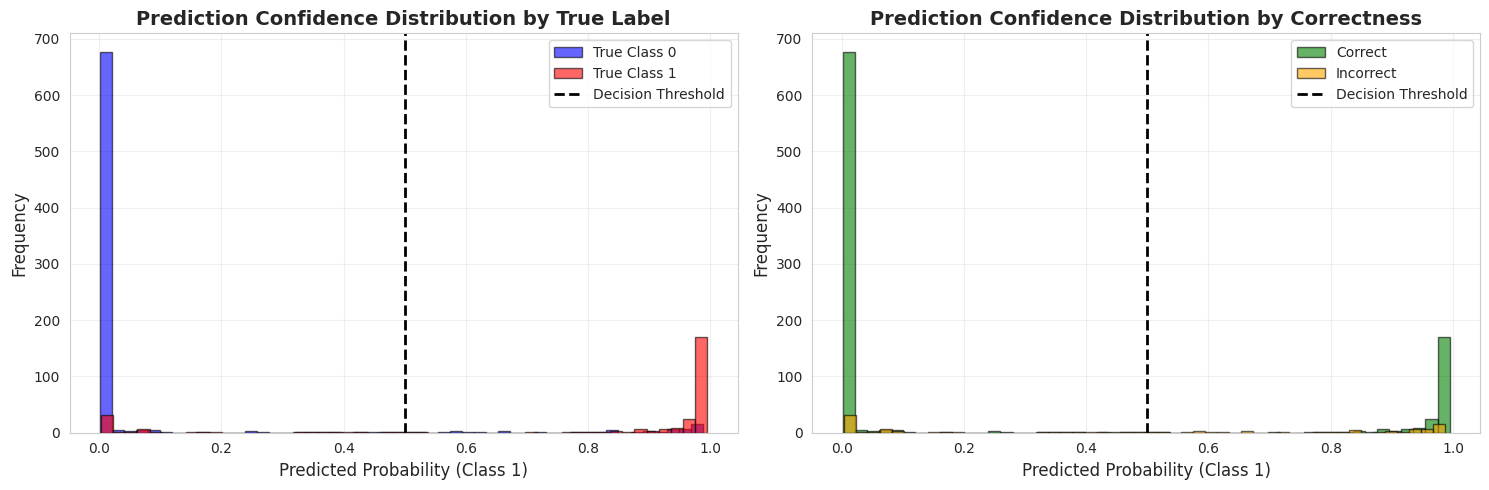

Low confidence predictions (0.4-0.6): 22/1060 (2.08%)
Average confidence for correct predictions: 0.2508
Average confidence for incorrect predictions: 0.4637


In [32]:
# Prediction Confidence Distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confidence distribution by true label
axes[0].hist(val_probs[val_true_labels == 0], bins=50, alpha=0.6, label='True Class 0', color='blue', edgecolor='black')
axes[0].hist(val_probs[val_true_labels == 1], bins=50, alpha=0.6, label='True Class 1', color='red', edgecolor='black')
axes[0].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
axes[0].set_xlabel('Predicted Probability (Class 1)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Prediction Confidence Distribution by True Label', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Confidence distribution by prediction correctness
correct_mask = (val_probs >= 0.5) == val_true_labels
axes[1].hist(val_probs[correct_mask], bins=50, alpha=0.6, label='Correct', color='green', edgecolor='black')
axes[1].hist(val_probs[~correct_mask], bins=50, alpha=0.6, label='Incorrect', color='orange', edgecolor='black')
axes[1].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
axes[1].set_xlabel('Predicted Probability (Class 1)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Prediction Confidence Distribution by Correctness', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
low_confidence = np.sum((val_probs > 0.4) & (val_probs < 0.6))
print(f'Low confidence predictions (0.4-0.6): {low_confidence}/{len(val_probs)} ({100*low_confidence/len(val_probs):.2f}%)')
print(f'Average confidence for correct predictions: {val_probs[correct_mask].mean():.4f}')
print(f'Average confidence for incorrect predictions: {val_probs[~correct_mask].mean():.4f}')

Computing probabilities: 100%|██████████| 67/67 [00:07<00:00,  9.18it/s]


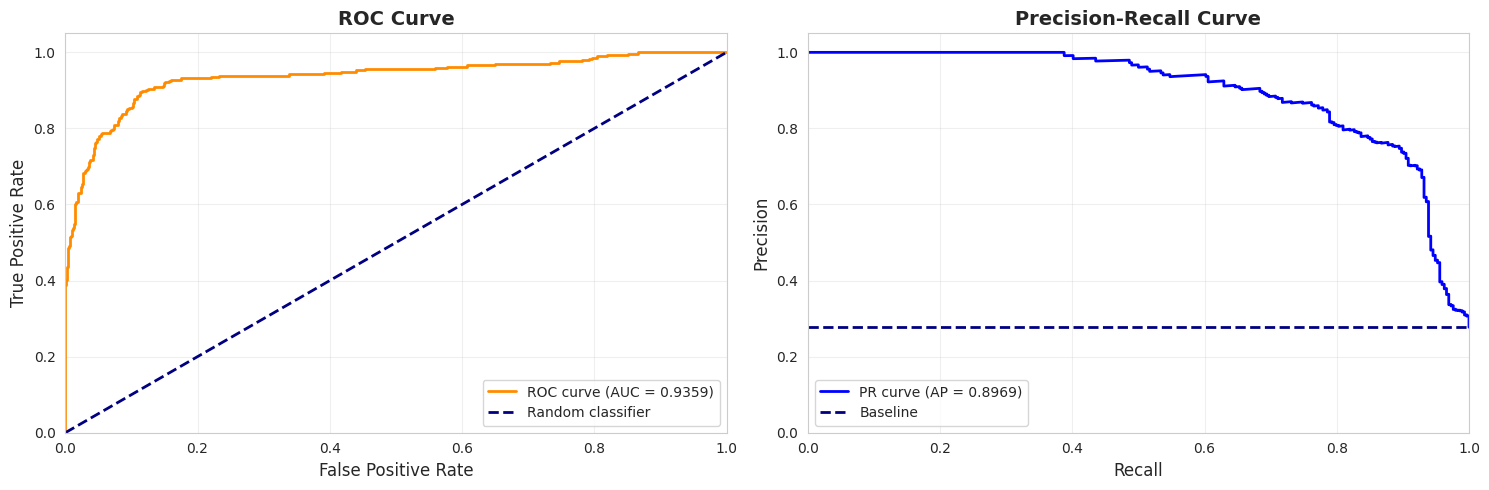

ROC AUC: 0.9359
Average Precision: 0.8969


In [33]:
# ROC Curve and Precision-Recall Curve
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Get prediction probabilities for validation set
model.eval()
val_probs = []
val_true_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc='Computing probabilities'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = F.softmax(outputs.logits, dim=1)
        val_probs.extend(probs[:, 1].cpu().numpy())
        val_true_labels.extend(labels.cpu().numpy())

val_probs = np.array(val_probs)
val_true_labels = np.array(val_true_labels)

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(val_true_labels, val_probs)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(val_true_labels, val_probs)
avg_precision = average_precision_score(val_true_labels, val_probs)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot ROC
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0].legend(loc="lower right")
axes[0].grid(alpha=0.3)

# Plot Precision-Recall
axes[1].plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')
axes[1].axhline(y=val_true_labels.sum()/len(val_true_labels), color='navy', linestyle='--', lw=2, label='Baseline')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower left")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f'ROC AUC: {roc_auc:.4f}')
print(f'Average Precision: {avg_precision:.4f}')